In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


### Load the dataset

In [2]:
df_cdnow_tr = pd.read_csv('data/cdnow.csv', index_col=0)

In [3]:
df_cdnow_tr.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [4]:
print(df_cdnow_tr.shape)
print('\n')
df_cdnow_tr.info()
# print('\n')
# print(df_retail_tr.describe())
# print('\n')
# print(df_retail_tr.head())

(69659, 4)


<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [5]:
df_cdnow_tr.nunique()

customer_id    23570
date             546
quantity          45
price           8208
dtype: int64

### Data Preparation

In [6]:
df_cdnow_tr['date'] = pd.to_datetime(df_cdnow_tr['date'])

df_cdnow_tr['year_month'] = df_cdnow_tr['date'].dt.to_period('M')
df_cdnow_tr['revenue'] = df_cdnow_tr['price'] * df_cdnow_tr['quantity']

df_cdnow_tr.head()

,customer_id,date,quantity,price,year_month,revenue
0,1,1997-01-01,1,11.77,1997-01,11.77
1,2,1997-01-12,1,12.00,1997-01,12.00
2,2,1997-01-12,5,77.00,1997-01,385.00
3,3,1997-01-02,2,20.76,1997-01,41.52
4,3,1997-03-30,2,20.76,1997-03,41.52


### Monthly Sales & Invoices

In [7]:
# aggregate monthly sale and count monthly unique invoices
df_monthly_revenue = df_cdnow_tr.groupby(['year_month']).agg({'revenue': 'sum', 'date': 'count'})
df_monthly_revenue.rename(columns={'revenue': 'sale', 'date': 'invoice_count'}, inplace=True)

df_monthly_revenue.reset_index(inplace=True)
df_monthly_revenue.head()

,year_month,sale,invoice_count
0,1997-01,1161982.39,8928
1,1997-02,1601779.41,11272
2,1997-03,1655292.85,11598
3,1997-04,683928.91,3781
4,1997-05,481138.62,2895


### Monthly revenue and transactions

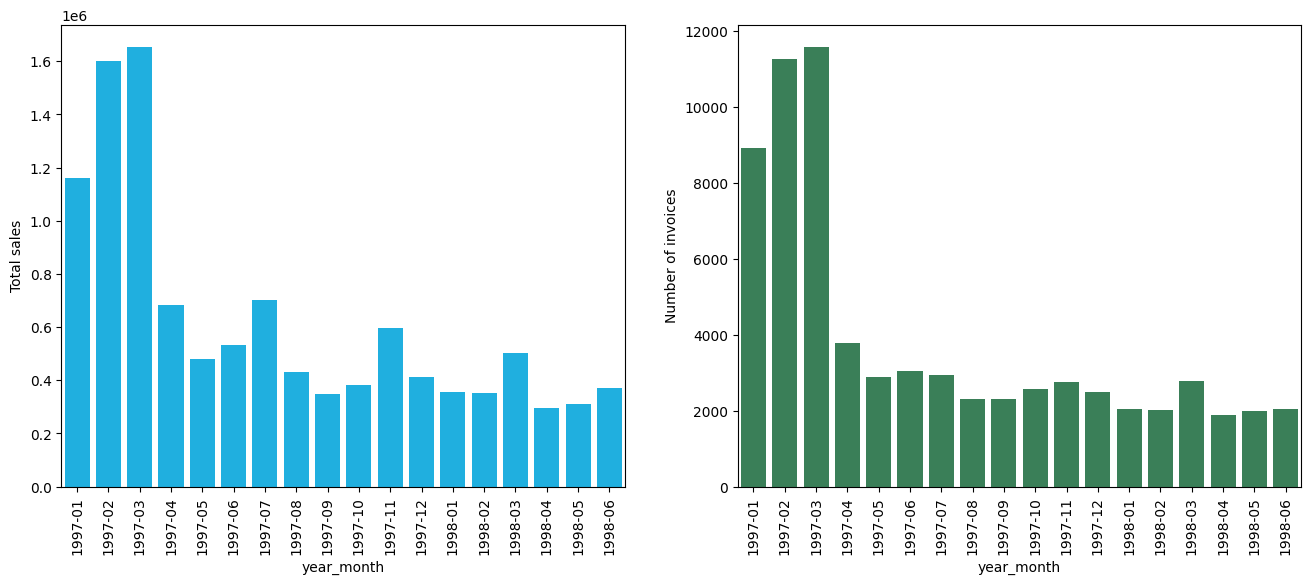

In [8]:
# plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# monthly total sales
s1 = sns.barplot(data=df_monthly_revenue, x='year_month', y='sale', ax=ax[0], color='deepskyblue')
# monthly total number of unique transactions
s2 = sns.barplot(data=df_monthly_revenue, x='year_month', y='invoice_count', ax=ax[1], color='seagreen')

s1.set_xticklabels(s1.get_xticklabels(), rotation=90)
s2.set_xticklabels(s2.get_xticklabels(), rotation=90)
s1.set_ylabel('Total sales')
s2.set_ylabel('Number of invoices')
plt.show()

---

# Customer's monthly revenue

In [9]:
df_monthly_sales = df_cdnow_tr.groupby(['customer_id', 'year_month']).agg({'revenue': 'sum'})
df_monthly_sales = df_monthly_sales.sort_values(by=['customer_id', 'year_month'])
df_monthly_sales.reset_index(inplace=True)
df_monthly_sales.head()

,customer_id,year_month,revenue
0,1,1997-01,11.77
1,2,1997-01,397.00
2,3,1997-01,41.52
3,3,1997-03,41.52
4,3,1997-04,39.08


### Customer's monthly revenue (all months)

In [10]:
# create a dataframe with only the year-month values
df_monthyear = pd.DataFrame({'year_month': df_cdnow_tr['year_month'].unique()})
# create a dataframe with only the customer-ids
df_customers = pd.DataFrame({'customer_id': df_cdnow_tr['customer_id'].unique()})
# cross join customer-ids with year-month
df_customer_yearmonth = df_customers.merge(df_monthyear, how='cross')
df_customer_yearmonth.head()

,customer_id,year_month
0,1,1997-01
1,1,1997-03
2,1,1997-04
3,1,1997-11
4,1,1998-05


In [11]:
df_monthly_sales = df_customer_yearmonth.merge(df_monthly_sales, on=['customer_id', 'year_month'], how='outer')
df_monthly_sales = df_monthly_sales.sort_values(by=['customer_id', 'year_month'])
df_monthly_sales['revenue'].fillna(0, inplace=True)
df_monthly_sales[df_monthly_sales['customer_id'] == 3]

,customer_id,year_month,revenue
36,3,1997-01,41.52
37,3,1997-02,0.00
38,3,1997-03,41.52
39,3,1997-04,39.08
40,3,1997-05,0.00
41,3,1997-06,0.00
42,3,1997-07,0.00
43,3,1997-08,0.00
44,3,1997-09,0.00
45,3,1997-10,0.00


In [12]:
df_monthly_sales_agg = df_monthly_sales.groupby('customer_id').rolling(18, on='year_month', min_periods=0).revenue.sum()
df_monthly_sales_agg = df_monthly_sales_agg.reset_index()
df_monthly_sales_agg = df_monthly_sales_agg.sort_values(by=['customer_id', 'year_month'])
df_monthly_sales_agg['year_month'] = df_monthly_sales_agg['year_month'].astype(str)

df_monthly_sales_agg[df_monthly_sales_agg['customer_id'] == 3]

,customer_id,year_month,revenue
36,3,1997-01,41.52
37,3,1997-02,41.52
38,3,1997-03,83.04
39,3,1997-04,122.12
40,3,1997-05,122.12
41,3,1997-06,122.12
42,3,1997-07,122.12
43,3,1997-08,122.12
44,3,1997-09,122.12
45,3,1997-10,122.12


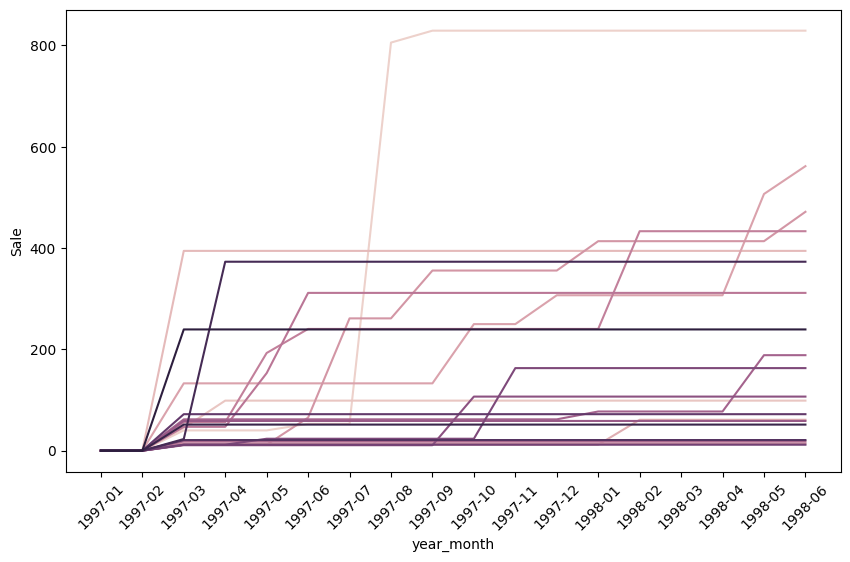

In [13]:
plt.figure(figsize=(10, 6))
s = sns.lineplot(
    data=df_monthly_sales_agg.iloc[-360:],
    x='year_month',
    y='revenue',
    hue='customer_id'
)
s.set_xticklabels(s.get_xticklabels(), rotation=45)
plt.ylabel('Sale')
plt.legend().remove()
plt.show()